# Unifying two datasets into one

- Football-Player-Detection (v8-resized1280_tile2x2_aug3x.yolov5pytorch)
    - Classes: football, player (one image marked null)
    - Resized to 1280x1280 (Stretch)
    - Normalised bb
    - very Augmented training set
- SOD_Dataset
    - Classes: ball, player
    - Annotations: For each image, there is a text file containing the class ID, Xmin, Ymin, Xmax, and Ymax, respectively.
    - yolov5_annotations: Box coordinates are in normalized xywh format (from 0 - 1) for yolov5_annotations. x_center and width are divided by image width, and y_center and height by image height.

 
 # Final dataset
 - Classes: football, player
 - Resized to 1280 x 720 (Stretch)
 - Annotations: For each image, there is a text file containing the class ID, Xmin, Ymin, Xmax, and Ymax, respectively. (bottom left, top right corners ?¿)

***
## Important Note
The two oringinal datasets must be downloaded into a "Datasets" folder in the parent folder of the repository:

Download from:
- https://github.com/FootballAnalysis/footballanalysis/tree/main/Dataset/Object%20Detection%20Dataset
- https://universe.roboflow.com/augmented-startups/football-player-detection-kucab

And name, respectively:
- SOD_Dataset
- Football-Player-Detection
***

### There is a file with an empty annotations folder, it needs to be removed from the "football-player-detection" dataset, I have added an exception so that it doesn't read the files: 
- 536_pp_jpg.rf.533a9e3c21d059812e90fe2547ab60a4.jpg  
- 536_pp_jpg.rf.533a9e3c21d059812e90fe2547ab60a4.txt 

In [6]:
import os
import torch
from PIL import Image
from torchvision import transforms
import numpy as np

# Create new directory for concatenated dataset
new_dataset_dir = "Datasets/Concatenated_Dataset/"
os.makedirs(new_dataset_dir, exist_ok = True)

image_final_dir = "Datasets/Concatenated_Dataset/images/"
os.makedirs(image_final_dir, exist_ok = True)

label_final_dir = "Datasets/Concatenated_Dataset/annotations/"
os.makedirs(label_final_dir, exist_ok = True)

new_file_name = "Sample_"
sample_n = 0


#new_size = (1280, 1280)
new_size = (320, 320)
resize = True


In [7]:
def checkBB(x_min, y_min, x_max, y_max):
    # prevent flipping, of the BB coordinates, pytorch gets angry otherwise
    if x_max < x_min:
        temp = x_min
        x_min = x_max
        x_max = temp
    if y_max < y_min:
        temp = y_min
        y_min = y_max
        y_max = temp

    # stop 0 width and 0 height BBs
    if abs(x_max - x_min) < 4:
        x_min -= 5
        x_max += 5
    if abs(y_max - y_min) < 4:
        y_min -= 5
        y_max += 5

    return x_min, y_min, x_max, y_max

# Reshaping SOD_Dataset and switching labels


In [8]:
from PIL import Image
import os
import shutil

# Set the path to your image directory
image_dir = "Datasets/SOD_Dataset/images"
# Set the path to your label directory
label_dir = "Datasets/SOD_Dataset/annotations"



# Loop through each image file in the directory
for filename in os.listdir(image_dir):
    # Open the image file using PIL

    original_im_dir = os.path.join(image_dir, filename)
    target_im_dir = os.path.join(image_final_dir, new_file_name + str(sample_n) + ".jpg")
    
    
    img = Image.open(original_im_dir)
    
    # Resize image
    if resize:
        new_image = img.resize(new_size)
        new_image.save(target_im_dir)
    else:
        shutil.copy(original_im_dir, target_im_dir)

    # Open the corresponding label file
    label_filename = os.path.splitext(filename)[0] + ".txt"
    label_path = os.path.join(label_dir, label_filename)
    with open(label_path, "r") as f:
        label_data = f.readlines()
     # Resize the bounding boxes in the label file
    new_label_data = []
    for line in label_data:
        parts = line.strip().split(" ")
        class_id = parts[0]
        bounding_box = parts[1:]

        x_min = float(bounding_box[0])
        y_min = float(bounding_box[1])
        x_max = float(bounding_box[2])
        y_max = float(bounding_box[3])
        
        if resize:
            # Resize the bounding box coordinates
            x_min_resized = int(x_min * (new_size[0] / img.width))
            y_min_resized = int(y_min * (new_size[1] / img.height))
            x_max_resized = int(x_max * (new_size[0] / img.width))
            y_max_resized = int(y_max * (new_size[1] / img.height))
        else:
            # Resize the bounding box coordinates
            x_min_resized = int(x_min * img.width)
            y_min_resized = int(y_min * img.height)
            x_max_resized = int(x_max * img.width)
            y_max_resized = int(y_max * img.height)

        x_min_resized, y_min_resized, x_max_resized, y_max_resized = checkBB(x_min_resized, y_min_resized, x_max_resized, y_max_resized)
            
        
        # Change class id to match other dataset:
        new_class_id = class_id # in case there is any null 
        if class_id == '0':
            new_class_id = '1'
        elif class_id == '1': 
            new_class_id = '0'
        
        new_parts = [new_class_id, str(x_min_resized), str(y_min_resized), str(x_max_resized), str(y_max_resized)]
        new_label_data.append(" ".join(new_parts))
    
        output_label_filename = os.path.splitext(new_file_name + str(sample_n))[0] + ".txt"
        output_label_path = os.path.join(label_final_dir, output_label_filename)
    with open(output_label_path, "w") as f:
        f.write("\n".join(new_label_data))
    
    sample_n += 1

# Modifying Bounding boxes in  Football-Player-Detection to correct format and joining datasets

In [9]:
from PIL import Image
import os
import shutil

# Set the path to your image directory
image_directories = ["Datasets/Football-Player-Detection/train/images", "Datasets/Football-Player-Detection/test/images", "Datasets/Football-Player-Detection/valid/images"]

# Set the path to your label directory
label_directories = ["Datasets/Football-Player-Detection/train/labels", "Datasets/Football-Player-Detection/test/labels", "Datasets/Football-Player-Detection/valid/labels"]

# RESIZING IS DEFINED IN THE PREVIOUS CODE

for image_dir, label_dir in zip(image_directories, label_directories):
    # Loop through each image file in the directory
    for filename in os.listdir(image_dir):

        if filename == "536_pp_jpg.rf.533a9e3c21d059812e90fe2547ab60a4.jpg":
            print("skipped erroneous file")
            continue # skips the rest of this iteration of the loop
        else:
        
            original_im_dir = os.path.join(image_dir, filename)
            target_im_dir = os.path.join(image_final_dir, new_file_name + str(sample_n) + ".jpg")

            img = Image.open(original_im_dir)

            if resize:
                new_image = img.resize(new_size)
                new_image.save(os.path.join(image_final_dir, new_file_name + str(sample_n) + ".jpg"))
            else:
                shutil.copy(original_im_dir, target_im_dir) # just copy over the file


            # Open the corresponding label file
            label_filename = os.path.splitext(filename)[0] + ".txt"
            label_path = os.path.join(label_dir, label_filename)

            with open(label_path, "r") as f:
                label_data = f.readlines()
            # Resize the bounding boxes in the label file
                # Resize the bounding boxes in the label file
            new_label_data = []
            for line in label_data:
                parts = line.strip().split(" ")
                x_center = float(parts[1])
                y_center = float(parts[2])
                box_width = float(parts[3])
                box_height = float(parts[4])
                
                # Convert normalized coordinates to pixel coordinates
                x_min = int((x_center - (box_width / 2)) * img.width)
                y_min = int((y_center - (box_height / 2)) * img.height)
                x_max = int((x_center + (box_width / 2)) * img.width)
                y_max = int((y_center + (box_height / 2)) * img.height)

                if resize:
                    x_min = int(x_min * (new_size[0] / img.width))
                    y_min = int(y_min * (new_size[1] / img.height))
                    x_max = int(x_max * (new_size[0] / img.width))
                    y_max = int(y_max * (new_size[1] / img.height))

                x_min, y_min, x_max, y_max = checkBB(x_min, y_min, x_max, y_max)
                
                new_parts = [parts[0], str(x_min), str(y_min), str(x_max), str(y_max)]
                new_label_data.append(" ".join(new_parts))
            
                output_label_filename = os.path.splitext(new_file_name + str(sample_n))[0] + ".txt"
                output_label_path = os.path.join(label_final_dir, output_label_filename)
            with open(output_label_path, "w") as f:
                f.write("\n".join(new_label_data))

            sample_n += 1
        

skipped erroneous file


## Splitting the main folder into train/validate/test folders randomly




In [10]:
from sklearn.model_selection import train_test_split


image_final_dir = "Datasets/Concatenated_Dataset/images/"
os.makedirs(image_final_dir, exist_ok = True)

label_final_dir = "Datasets/Concatenated_Dataset/annotations/"


print(len(os.listdir(image_final_dir)))
print(len(os.listdir(label_final_dir)))

#files = [os.path.splitext(imgfile)[0] for imgfile in os.listdir(image_final_dir)]
#files2 = [os.path.splitext(imgfile)[0] for imgfile in os.listdir(label_final_dir)]

image_files = os.listdir(image_final_dir)
label_files = os.listdir(label_final_dir)

# 20% testing set, 20% validation, 60% training
X_train, X_test, y_train, y_test = train_test_split(image_files, label_files, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

image_splits = [X_train, X_val, X_test]
label_splits = [y_train, y_val, y_test]
folders = ["train", "valid", "test"]

for idx, set in enumerate(folders):

    dir = "Data/" + set
    img_dir = dir + "/images"
    label_dir = dir + "/labels"

    os.makedirs(img_dir, exist_ok = True)
    os.makedirs(label_dir, exist_ok = True)

    images = image_splits[idx]
    labels = label_splits[idx]
    for img_file in images:
        original_im_dir = os.path.join(image_final_dir, img_file)
        target_im_dir = os.path.join(img_dir, img_file)

        shutil.copy(original_im_dir, target_im_dir)

    for label_file in labels:
        original_lab_dir = os.path.join(label_final_dir, label_file)
        target_lab_dir = os.path.join(label_dir, label_file)

        shutil.copy(original_lab_dir, target_lab_dir)

print("done saving train/valid/test folders!")

2231
2231
done saving train/valid/test folders!


## Data Augmentation

In [10]:
def rotate(origin, point, angle):
    ox, oy = origin # center original image
    px, py = point # bounding box corners

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return int(qx), int(qy)

In [13]:
import random
import imgaug.augmenters as iaa
import cv2

def rotate(origin, point, angle):
    ox, oy = origin # center original image
    px, py = point # bounding box corners

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return int(qx), int(qy)


def data_augmentation(img_dir, img_name, label_path, img_final_dir, label_final_dir, sample_n = 0):
    image_original = cv2.imread(os.path.join(img_dir, img_name))
    augmented_file_name = "augm_sample_"

    hflip= iaa.Fliplr(p=1.0) # p: probability of being transformed
    #vertical flip
    vflip= iaa.Flipud(p=1.0) # p: probability of being transformed
    #image rotation
    angle = random.randrange(-90,90) # can be changed
    rot1 = iaa.Affine(rotate=(angle, angle))
    #noise
    noise = iaa.AdditiveGaussianNoise(random.randrange(-50,0),random.randrange(50))
    #hue and saturation
    hue_saturation = iaa.AddToHueAndSaturation((-25, 25), per_channel=True)
    #brightness
    brightness = iaa.MultiplyAndAddToBrightness(mul=(0.8, 1.2), add=(-30, 30))

    #crop 
    # Did not finish these labels transformation
    cropped_percent = random.uniform(0.1, 0.45)
    crop1 = iaa.Crop(percent=cropped_percent) # fraction removed from all sides of the image 
                                              # E.g. if this is set to 0.1, the augmenter will always crop 10% of the image’s
                                              # height at both the top and the bottom (both 10% each), as well as 10% of the width at the right and left
    
    #shear (already a random amount)
    #shear = iaa.Affine(shear=(-20,20)

    func_labels = ["hflip", "vflip", "rotation", "noise", "hue_saturation", "brightness"]
    funcs=[hflip, vflip, rot1, noise, hue_saturation, brightness]

    
    # randmly sample some number of transformations to do
    num_of_transforms = random.randint(1, len(funcs)-1)
    if num_of_transforms == 1:
        randInt = random.randint(0, len(funcs)-1)
        random_func_labels = [func_labels[randInt]]
        random_funcs = [funcs[randInt]]
    else:
        random_func_labels, random_funcs = zip(*random.sample(list(zip(func_labels, funcs)), num_of_transforms))
    #print(random_func_labels)

    # TRANSFORM THE IMAGES
    new_img = image_original
    for function in random_funcs:
        new_img = function.augment_image(new_img)
    
    augmented_image = Image.fromarray(new_img)
    augmented_image.save(os.path.join(img_final_dir, augmented_file_name + str(sample_n)+".jpg"))
    
    #TRANSFORM THE BOUNDING BOXES
    non_BB_transforms = ["noise", "hue_saturation", "brightness"] # these are the transformations that don't require BB transforms
    if all(item in random_func_labels for item in non_BB_transforms):  # check that all transforms are of these types, otherwise we have work to do
        target_lab_dir = os.path.join(label_final_dir, augmented_file_name + str(sample_n)+".txt")
        shutil.copy(label_path, target_lab_dir)

    else:
        
        with open(label_path, "r") as f:
            label_data = f.readlines()
        # Resize the bounding boxes in the label fileç
        new_label_data = []
        for line in label_data:
            parts = line.strip().split(" ")
            x_min = float(parts[1])
            y_min = float(parts[2])
            x_max = float(parts[3])
            y_max = float(parts[4])

            # do the transformations of the BBs for functions that require it
            # loop through them so that the BB transforms are done in the same order as the Img transforms
            for funcLabel in [funcLabel for funcLabel in random_func_labels if funcLabel not in non_BB_transforms]:

                # Convert bounding boxes after transformation
                if funcLabel == "hflip":
                    x_min_new = int(augmented_image.width - x_min -1)
                    y_min_new = y_min
                    x_max_new = int(augmented_image.width - x_max -1)
                    y_max_new = y_max
                elif funcLabel == "vflip":
                    x_min_new = x_min
                    y_min_new = int(augmented_image.height - y_min -1)
                    x_max_new = x_max
                    y_max_new = int(augmented_image.height - y_max -1)
                elif funcLabel == "rotation":
                    cx = int(np.shape(image_original)[0]/ 2)
                    cy = int(np.shape(image_original)[1] / 2)
                    bottom_left = rotate([cx, cy], [x_min, y_min], np.radians(angle))
                    top_right = rotate([cx, cy], [x_max, y_max], np.radians(angle))
                    x_min_new = bottom_left[0]
                    y_min_new = bottom_left[1]
                    x_max_new = top_right[0]
                    y_max_new = top_right[1]
                else:
                    print("HELLO")

                x_min = x_min_new
                y_min = y_min_new
                x_max = x_max_new
                y_max = y_max_new

                x_min, y_min, x_max, y_max = checkBB(x_min, y_min, x_max, y_max)
        
            new_parts = [parts[0], str(x_min), str(y_min), str(x_max), str(y_max)]
            new_label_data.append(" ".join(new_parts))
            output_label_filename = os.path.splitext(augmented_file_name + str(sample_n))[0] + ".txt"
            output_label_path = os.path.join(label_final_dir, output_label_filename)

        with open(output_label_path, "w") as f:
            f.write("\n".join(new_label_data))


        sample_n += 1
    return sample_n


In [14]:

dir = "Data/train" 
img_dir = dir + "/images"
label_dir = dir + "/labels"
sample_n = 0
#img_final_dir
#label_final_dir


for filename in os.listdir(img_dir):
    # Open the corresponding label file
    label_filename = os.path.splitext(filename)[0] + ".txt"
    label_path = os.path.join(label_dir, label_filename)
    for i in range(3): # do 3 random transform sets (so 1 original + 3 new, per original img)
        sample_n = data_augmentation(img_dir, filename, label_path, img_dir, label_dir, sample_n) 
   
    #img_dir, img_name, label_path, img_final_dir, label_final_dir, sample_n = 0

# Loading Train/Validation/Test

In [4]:
from torch.utils.data import DataLoader
from src.dataLoading import playersDataset, collate_fn
import torch

# set the device (GPU is much faster)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_workers = 1 if torch.cuda.is_available() else 0
batch_size = 32 # LOWER THIS IF NEEDED!

train_dir = "Data/train/"
valid_dir = "Data/valid/"
test_dir = "Data/valid/"
train_dataset = playersDataset(train_dir)
validation_dataset = playersDataset(valid_dir)
test_dataset = playersDataset(test_dir)

# Define the dataloaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

14


ValueError: num must be 1 <= num <= 16, not 17

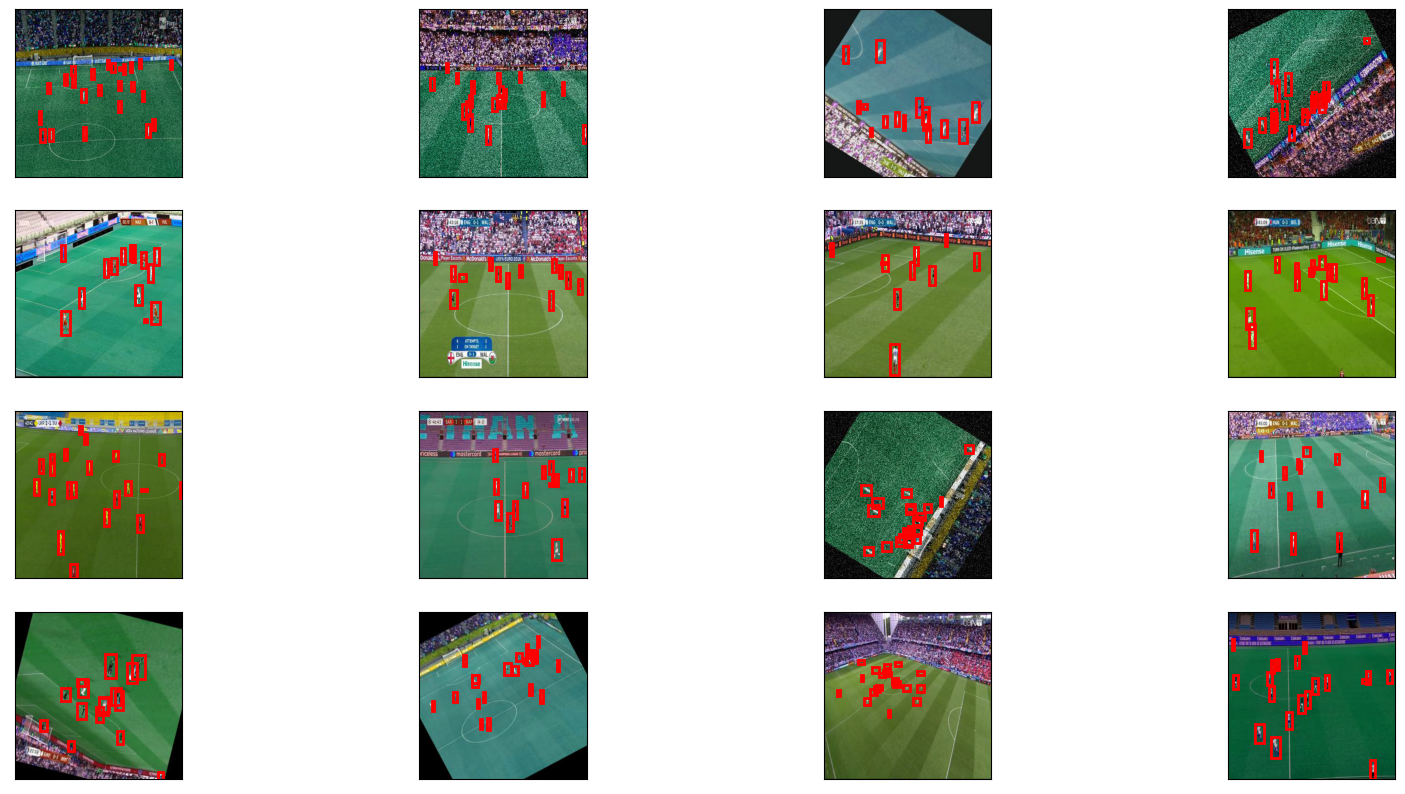

In [5]:
from torchvision.utils import draw_bounding_boxes, save_image
from torchvision.io import read_image
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.ops import box_convert

import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_imgs(imgs, annotations, rows, cols):
    CLASSES = ["ball", "player"]
    fig = plt.figure(figsize=(20,10))

    for i in range(len(imgs)):
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])

        boxes = annotations[i]['boxes']
        labels = annotations[i]['labels']

        img = imgs[i].numpy().transpose(1, 2, 0)
        ax.imshow(img, origin='upper')

        for j, box in enumerate(boxes):
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='r', facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

           # ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')
    #plt.show()


input, output = next(iter(train_loader))
fig = visualize_imgs(input, output, rows=4, cols=4)

In [6]:
def checkAllBBs(imgs, annotations, counter):
    for i in range(len(imgs)):

        boxes = annotations[i]['boxes']
        labels = annotations[i]['labels']

        for j, box in enumerate(boxes):
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            if width <= 3 or height <= 3:
                print(box)
                print("ERROR")

        counter+=1

    return counter


counter = 0
print("train")
for i, (images, targets) in enumerate(train_loader):
    counter = checkAllBBs(images, targets, counter)
print("val")
for i, (images, targets) in enumerate(val_loader):
    counter = checkAllBBs(images, targets, counter)
print("test")
for i, (images, targets) in enumerate(test_loader):
    counter = checkAllBBs(images, targets, counter)

print(counter)

train
val
test
94225
